In [1]:
!pip install svgpath2mpl

In [2]:
from collections import namedtuple
import numpy as np
import torch
import torch.nn as nn
import imageio
from svgpath2mpl import parse_path
import matplotlib.pyplot as plt
import matplotlib
from scipy.ndimage import rotate, shift
from matplotlib.animation import FuncAnimation
from probabilistic_fire_env import ProbabilisticFireEnv
from drone_env import DronesEnv
from networks.ppo_net import PPONet
from torch.distributions import MultivariateNormal, Categorical

In [3]:
DT          = 0.5  # Time between wildfire updates            
DTI         = 0.1  # Time between aircraft decisions
n_actions = 2
height = width = 100
channels = 2
EPISODES_PER_BATCH = 1
TRAIN_FREQ  = 10
SAVE_FREQ = 10
GAMMA = 0.95
CLIP  = 0.2
BATCH_SIZE = 64

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actor = PPONet(device,  channels, height, width, n_actions).to(device)
actor.load_state_dict(torch.load('ppo_actor.pth'))

<All keys matched successfully>

In [ ]:
class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    
    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([

/tmp/ipykernel_32/1293295273.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 5, figsize=(28, 4))


tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([

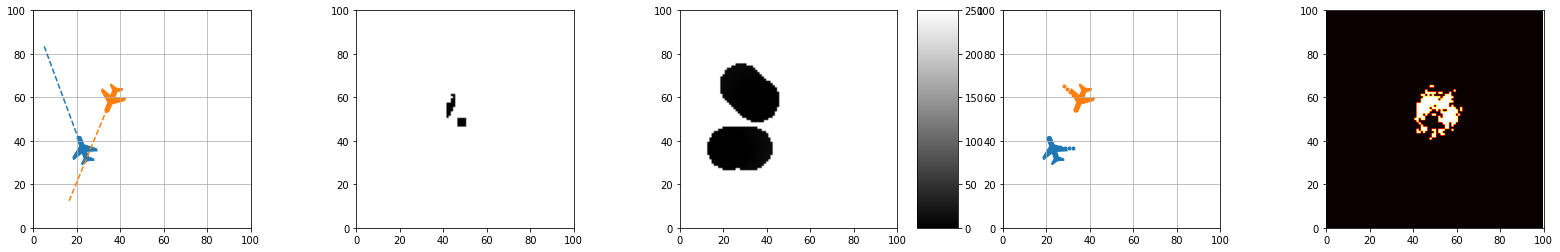

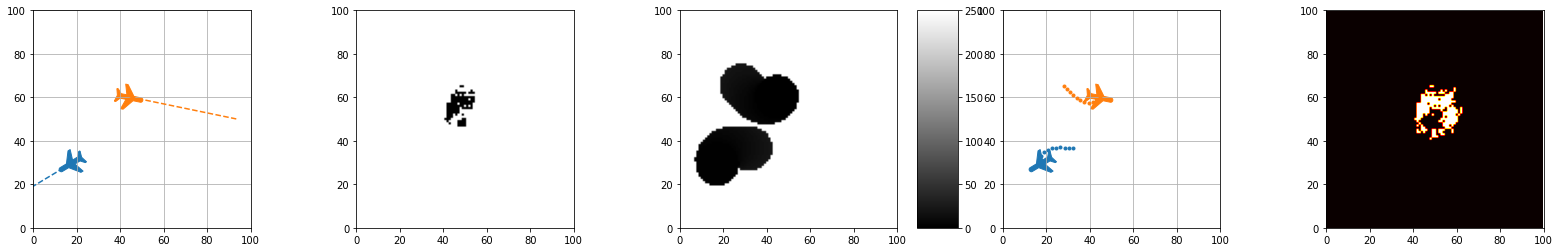

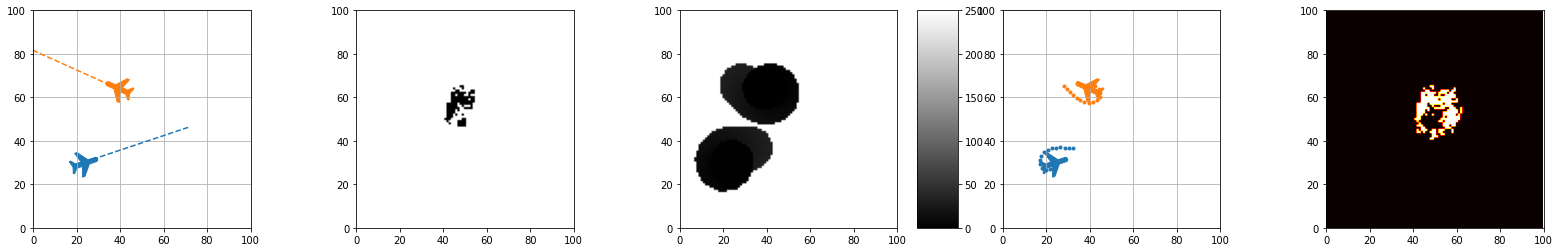

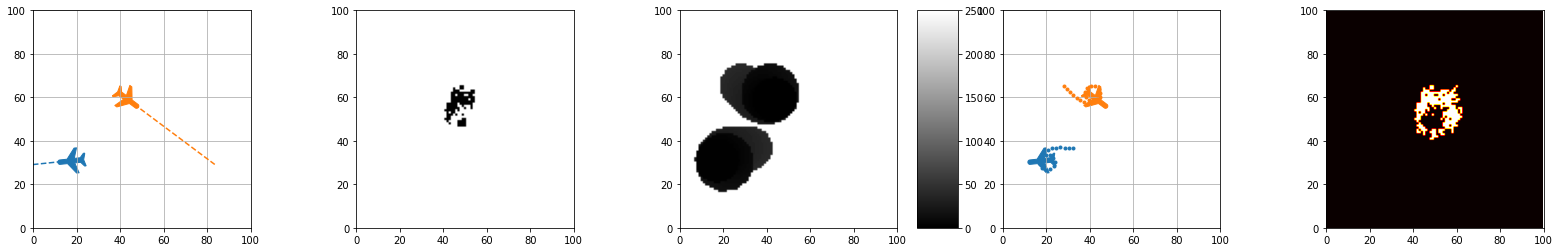

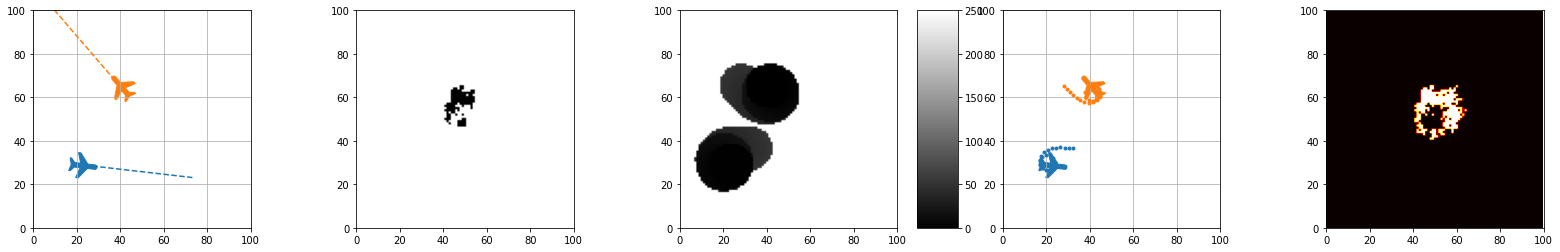

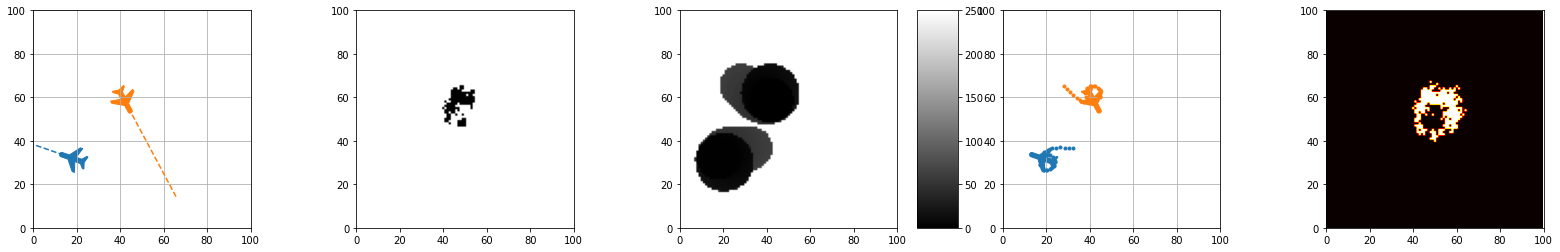

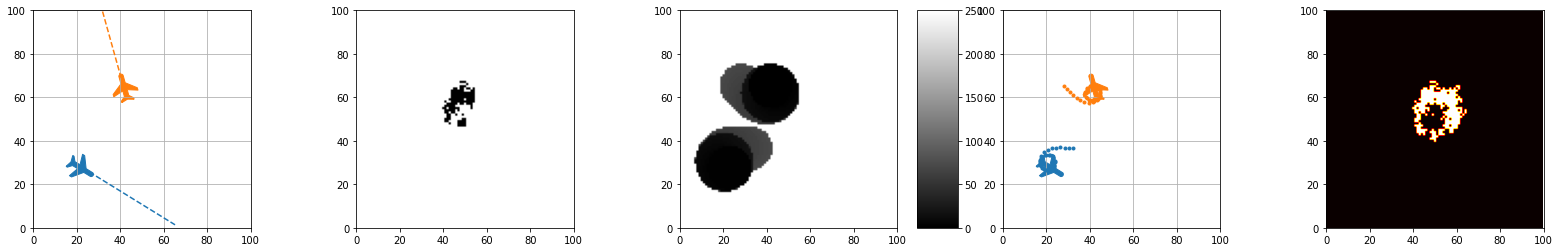

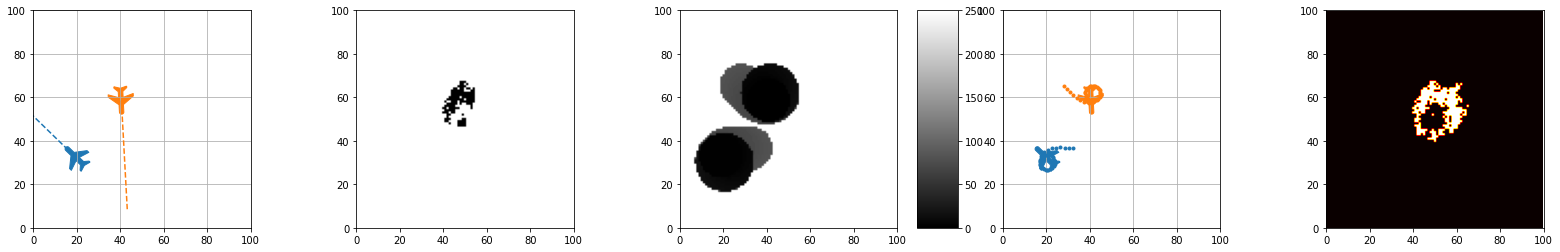

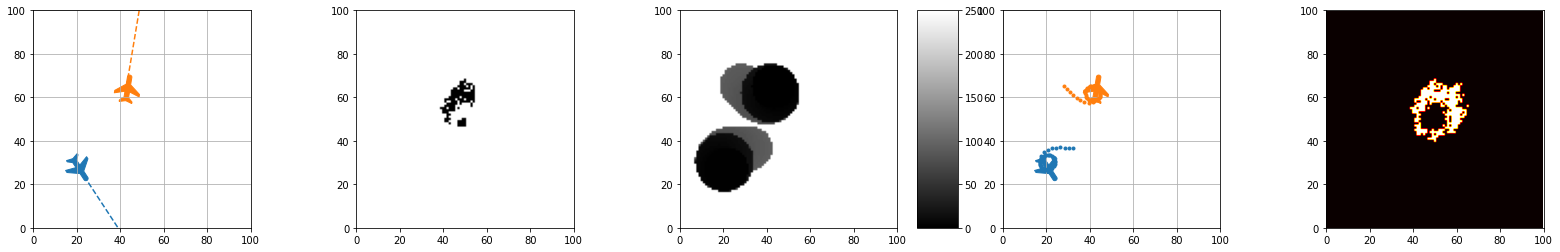

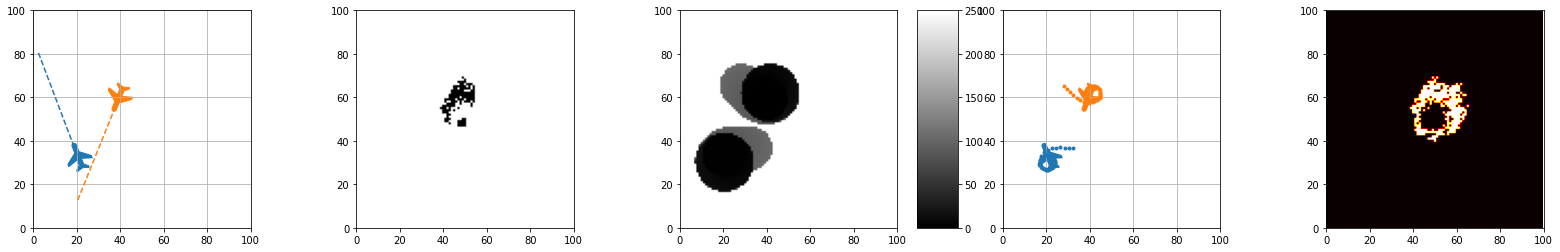

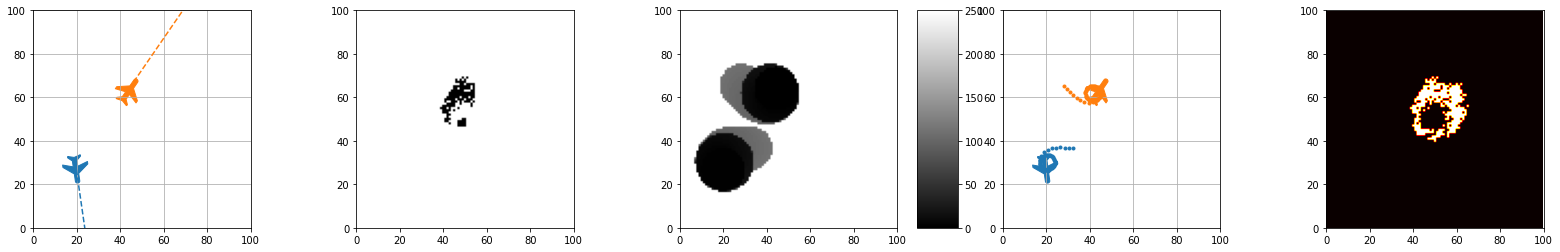

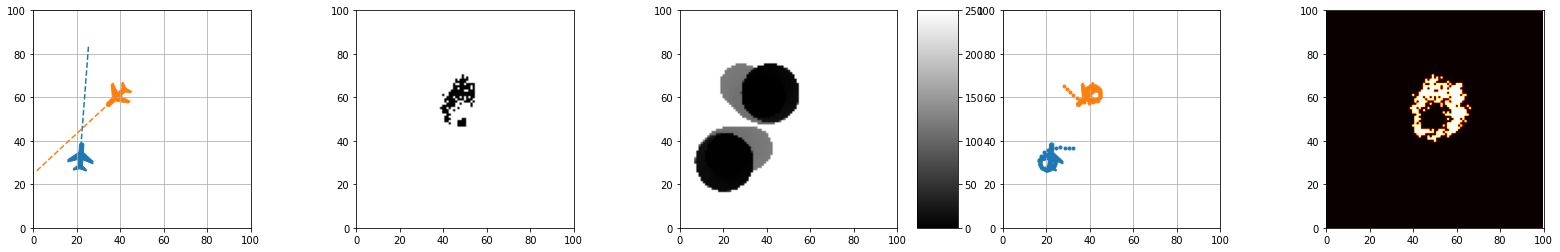

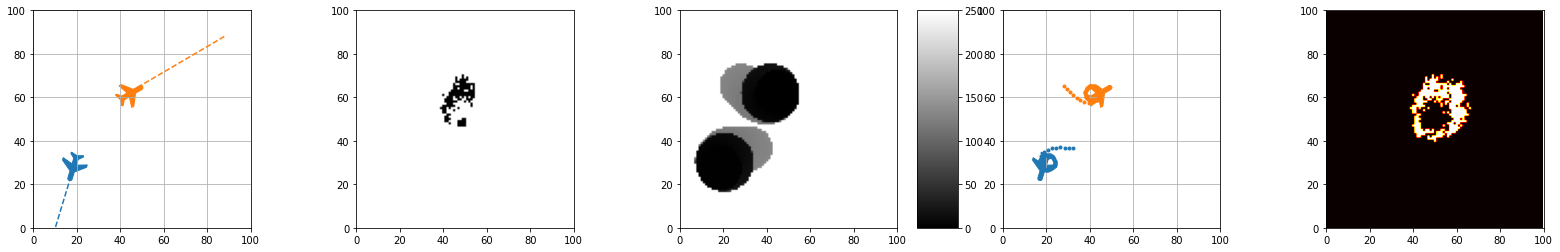

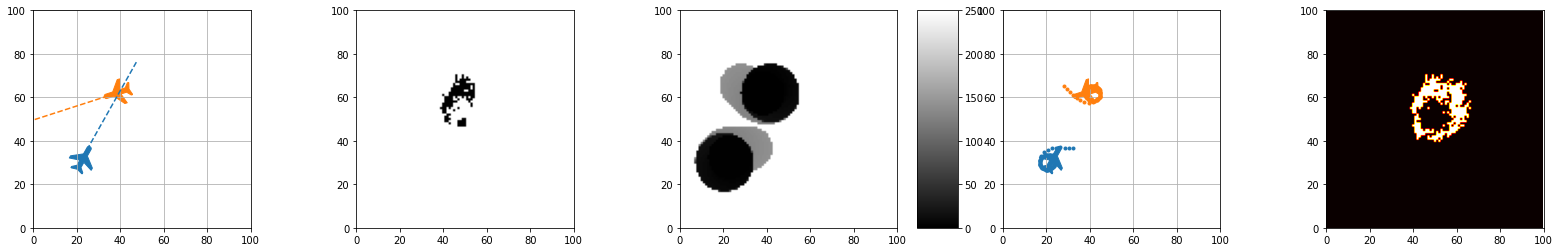

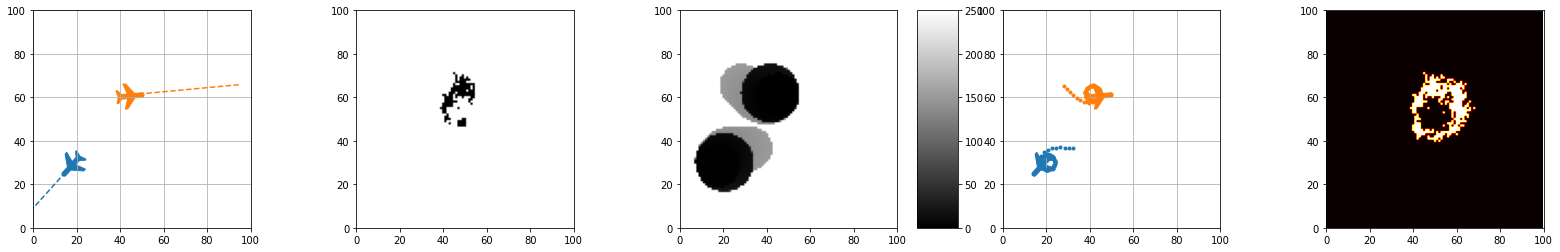

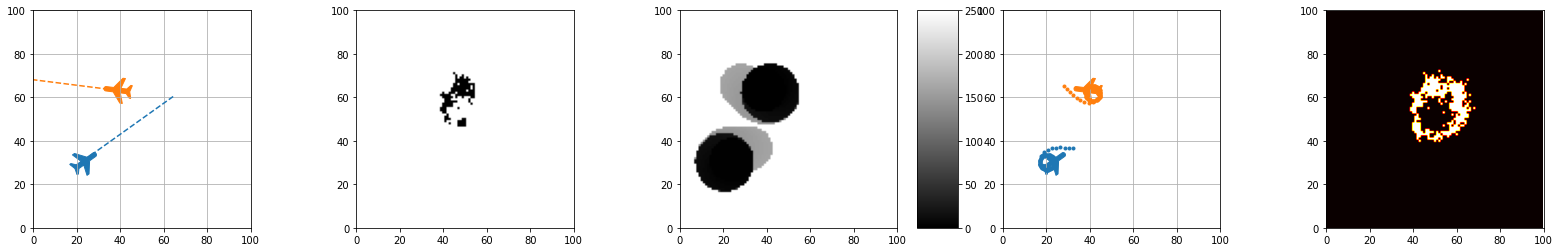

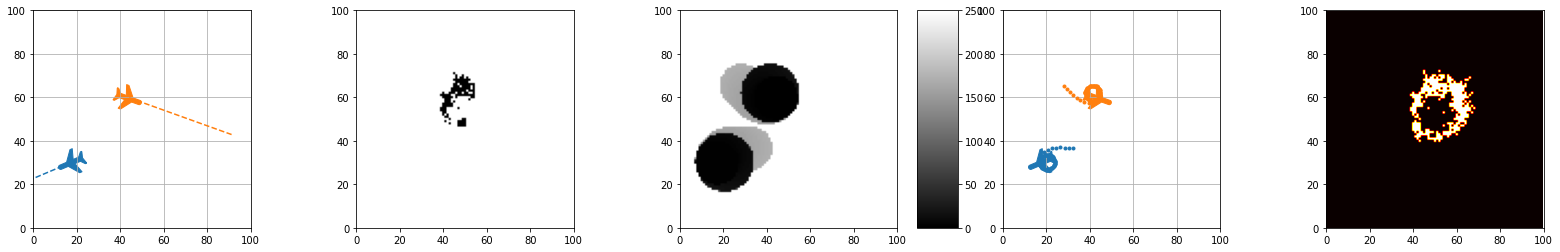

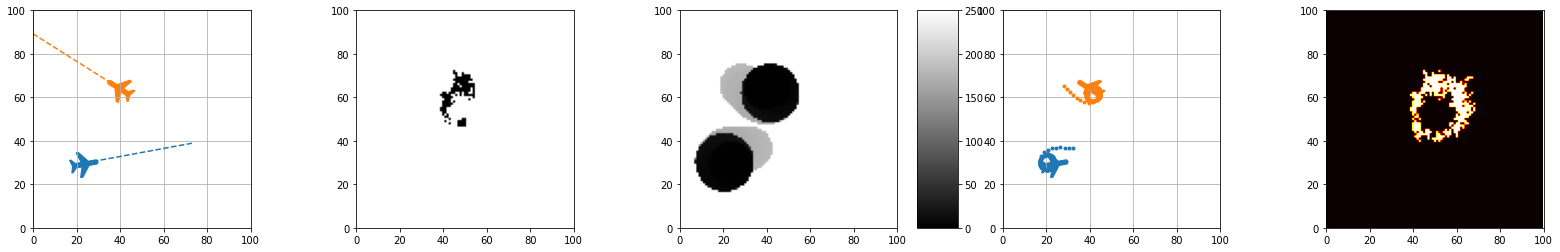

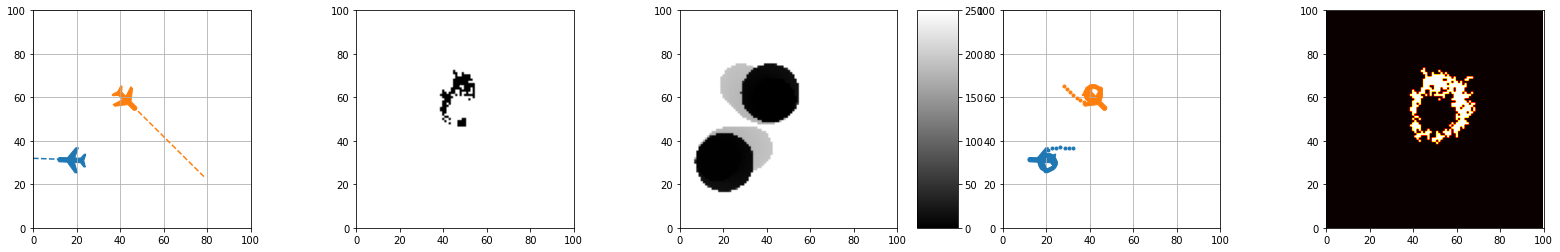

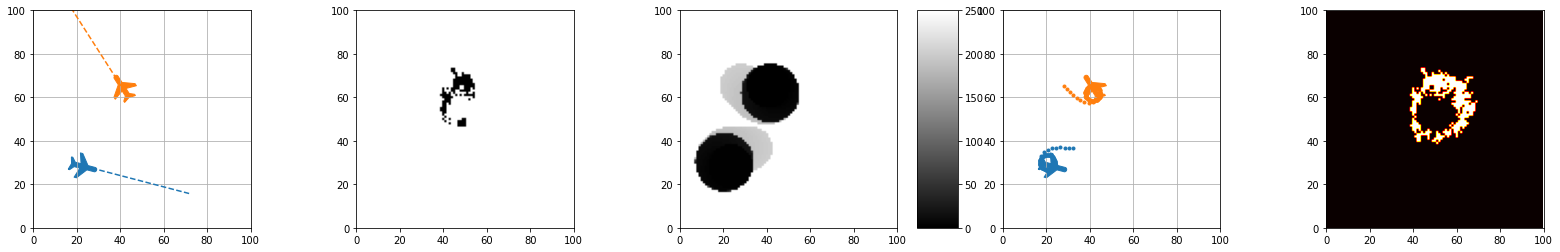

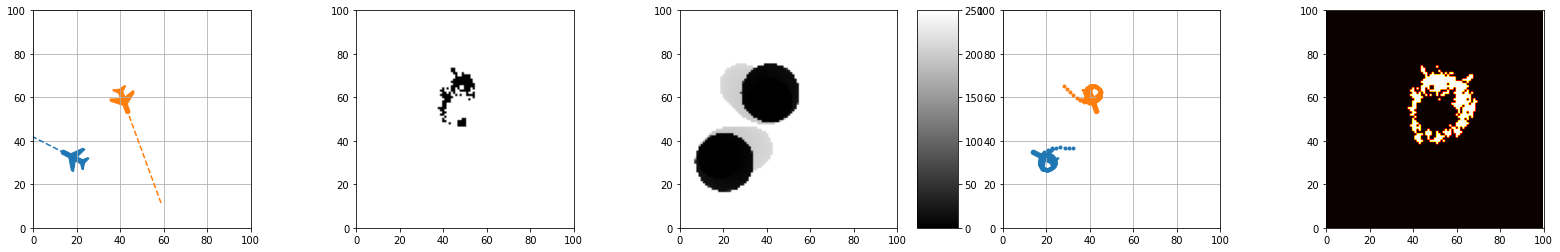

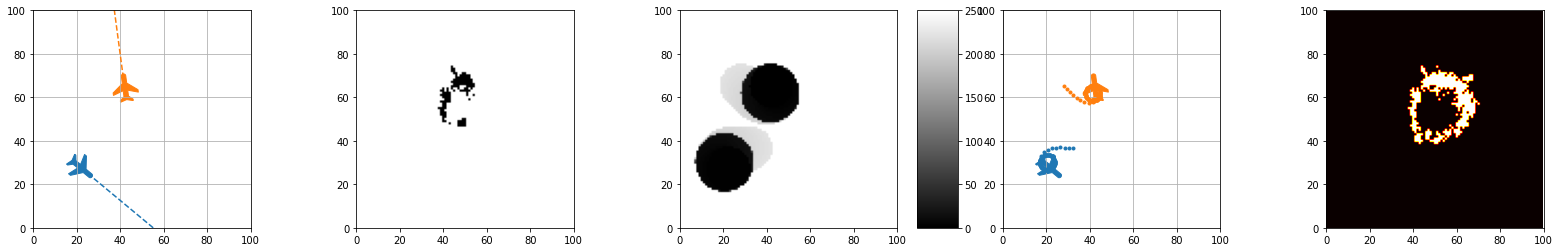

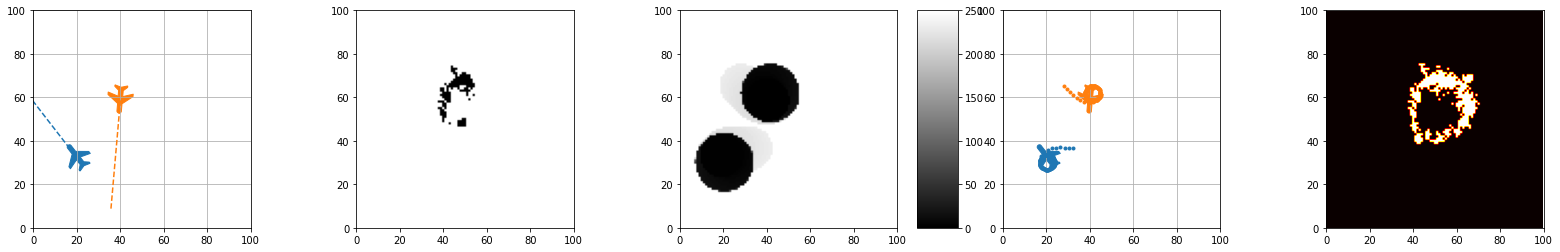

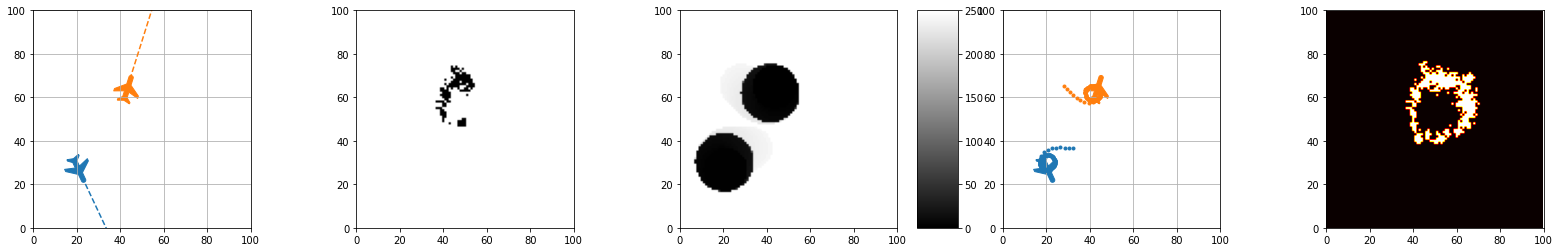

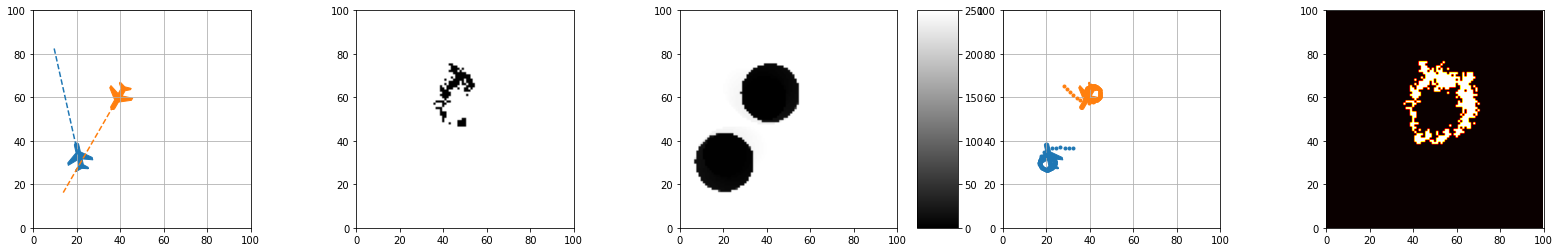

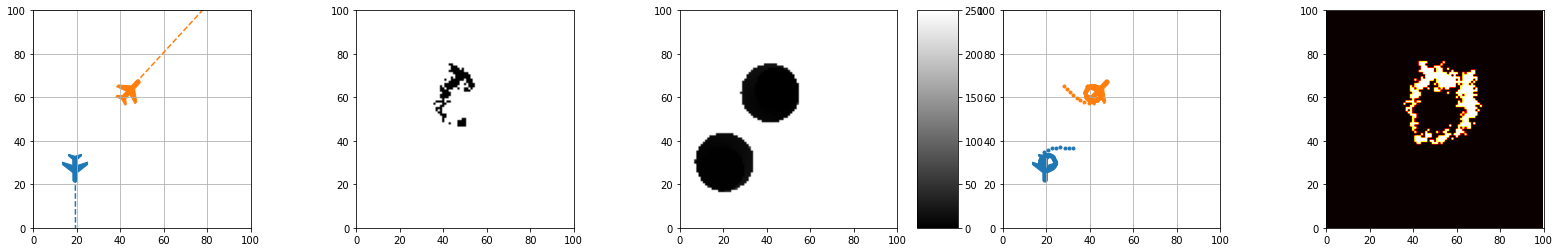

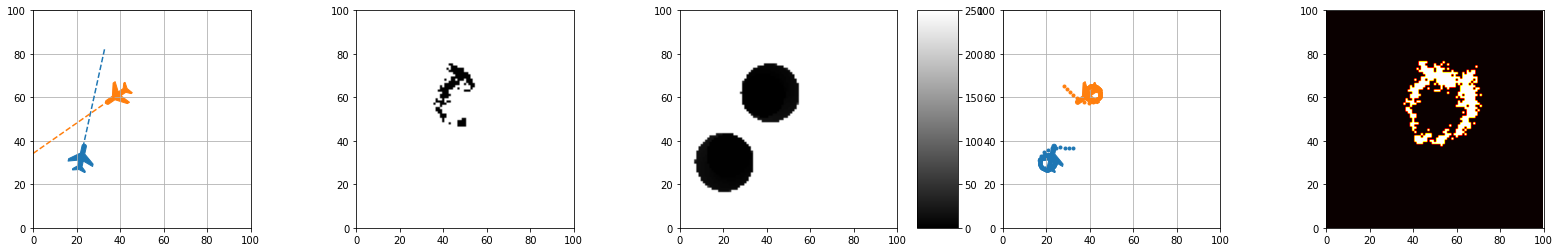

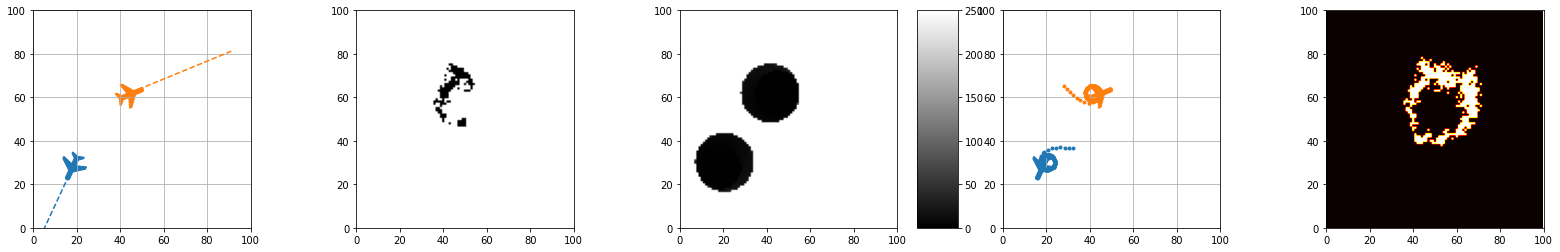

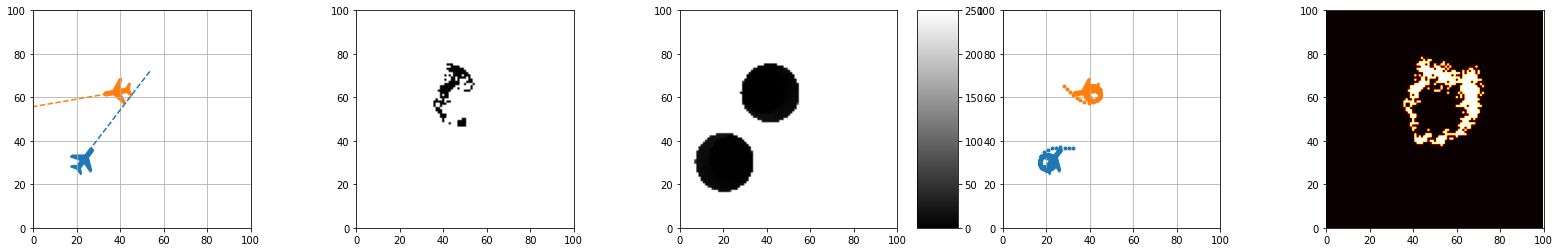

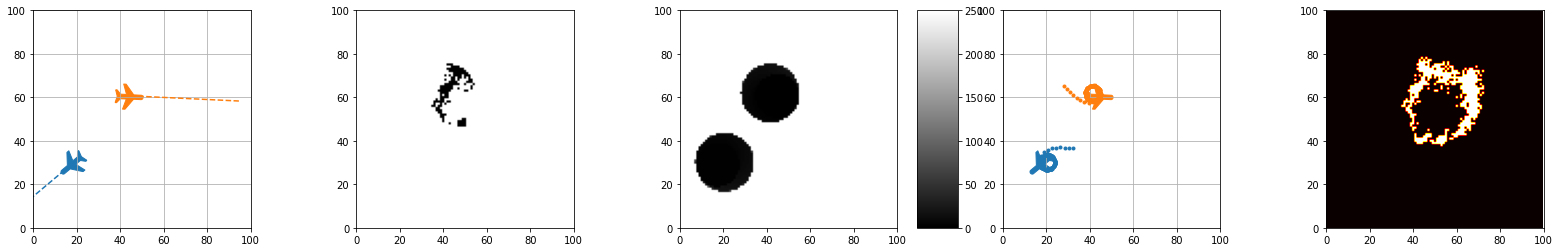

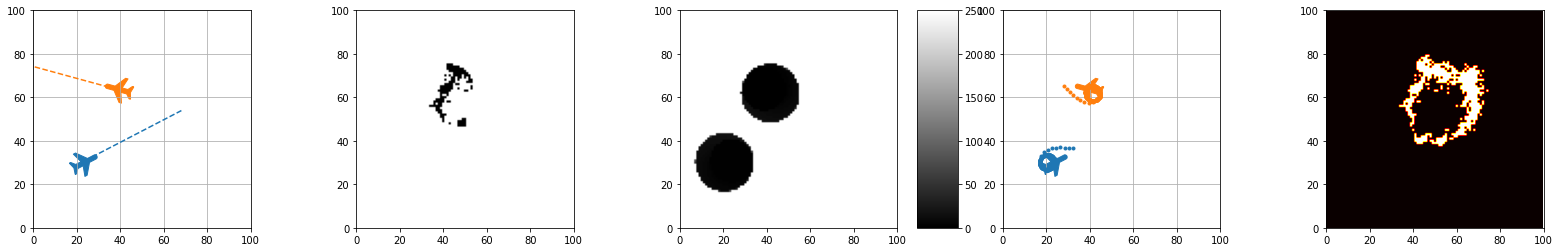

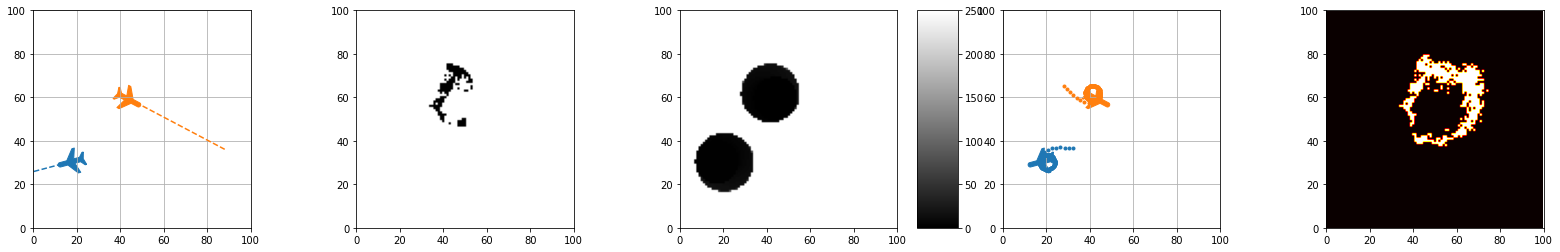

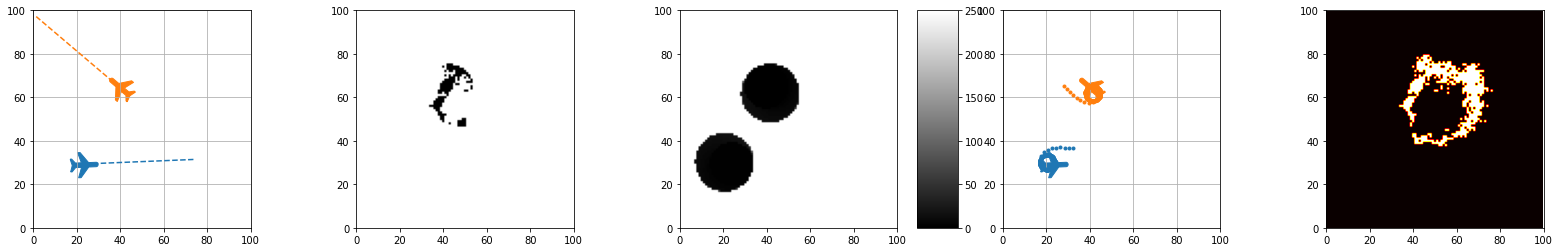

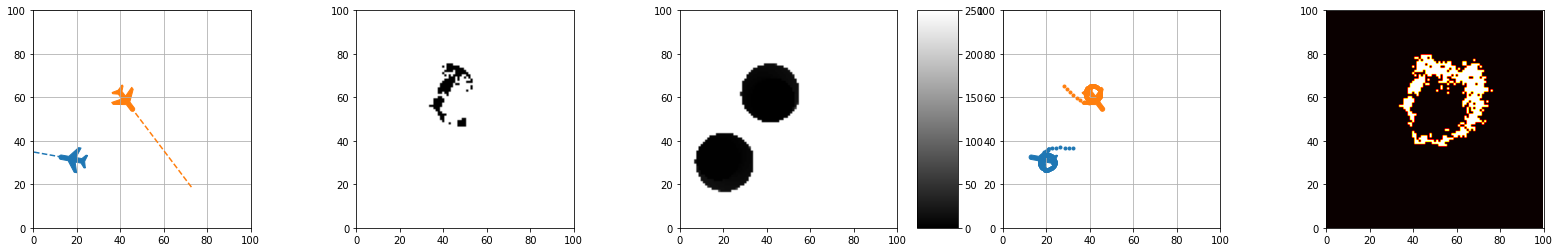

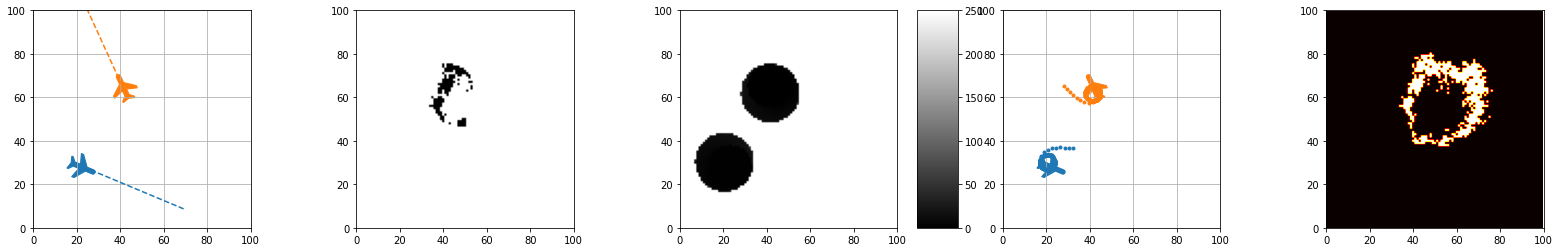

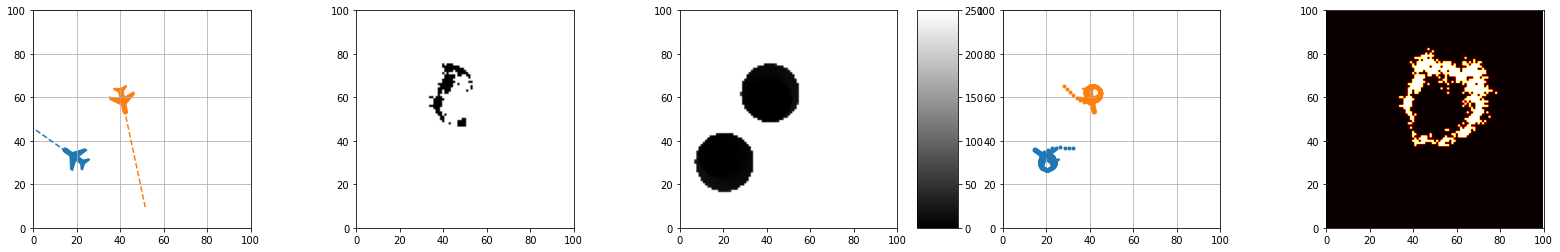

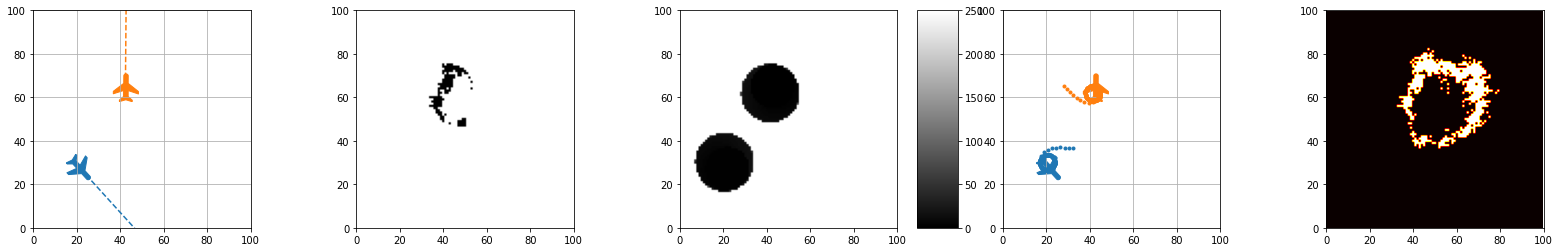

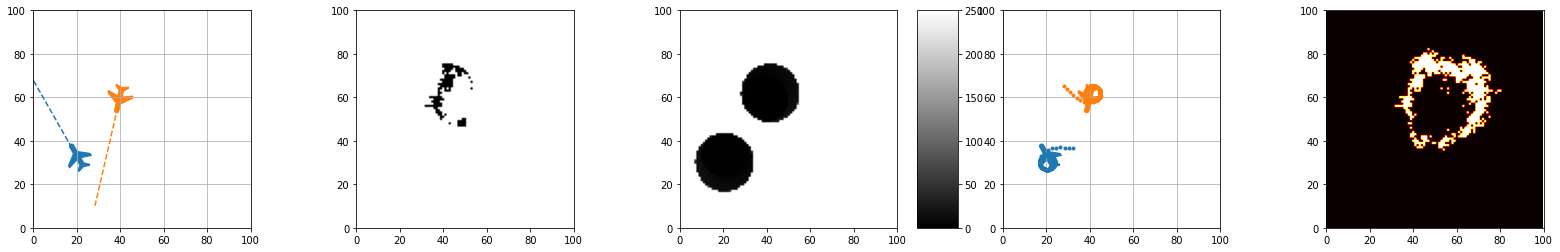

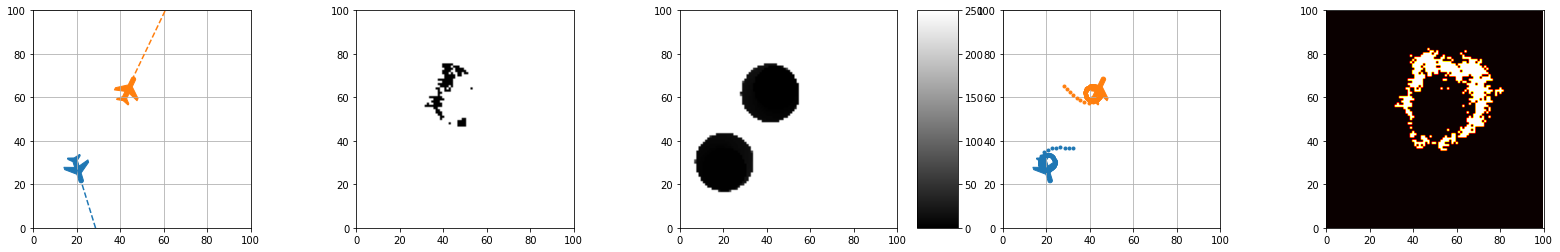

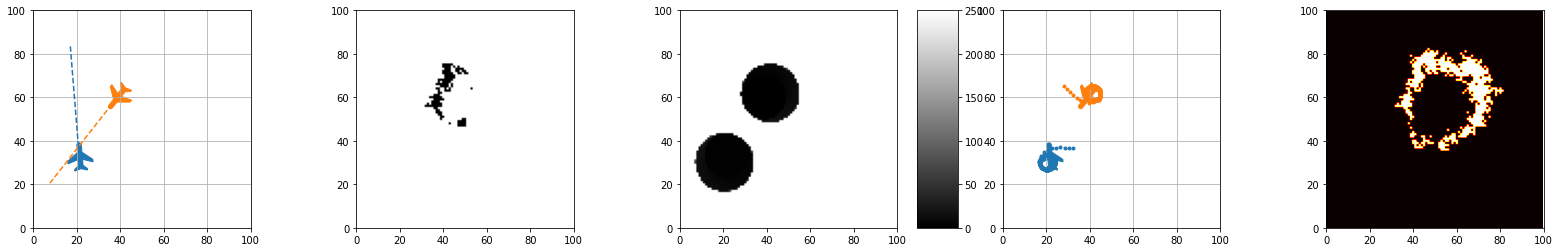

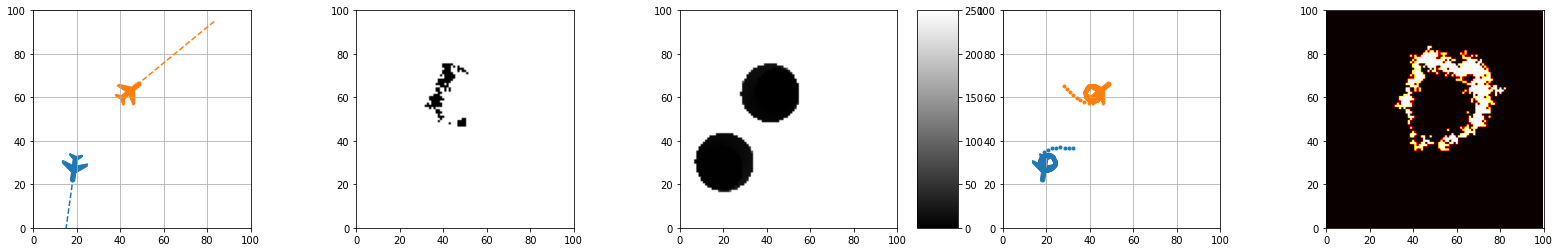

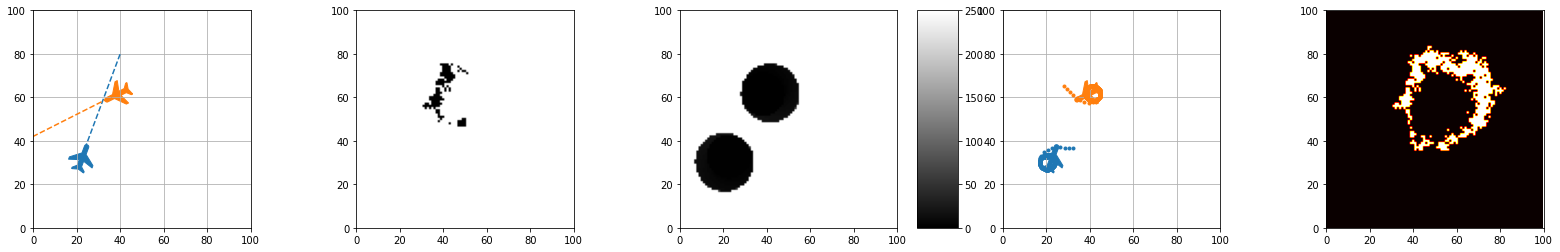

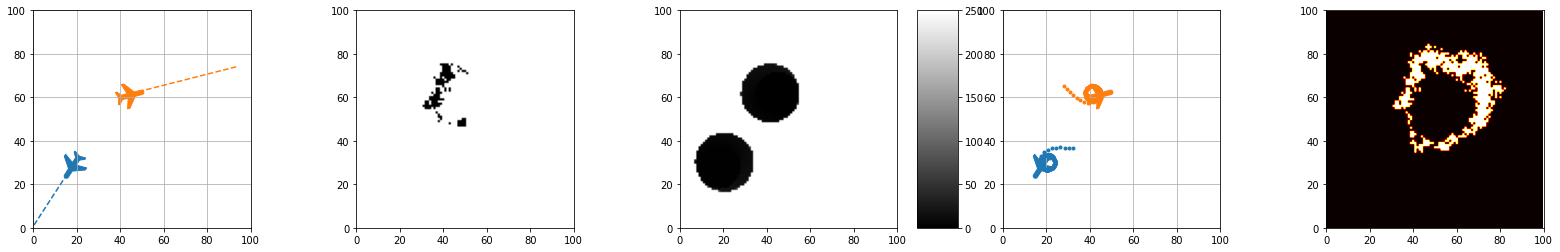

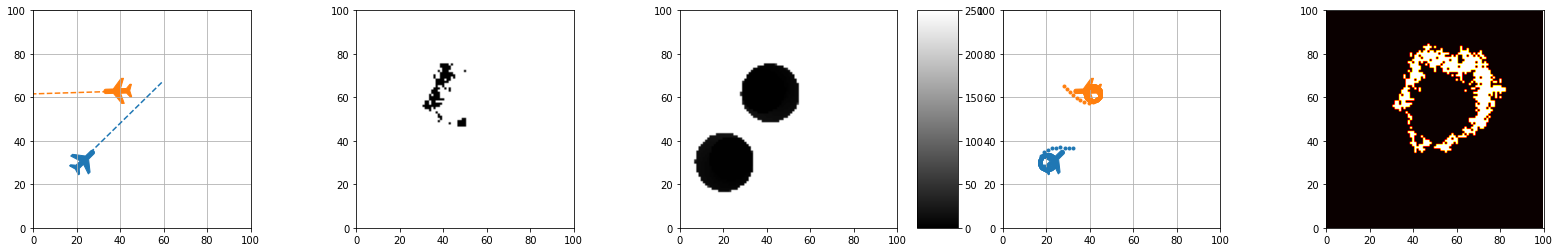

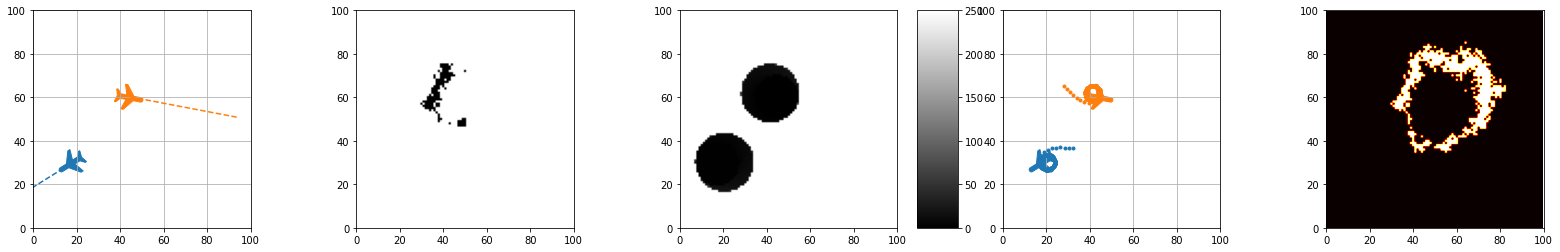

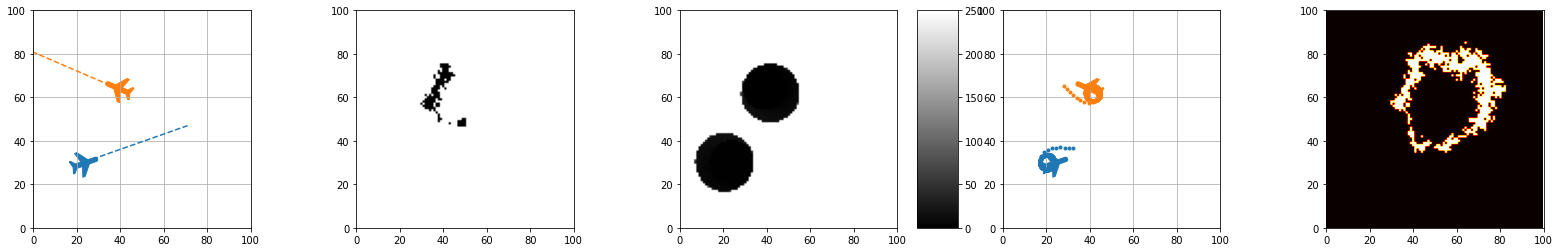

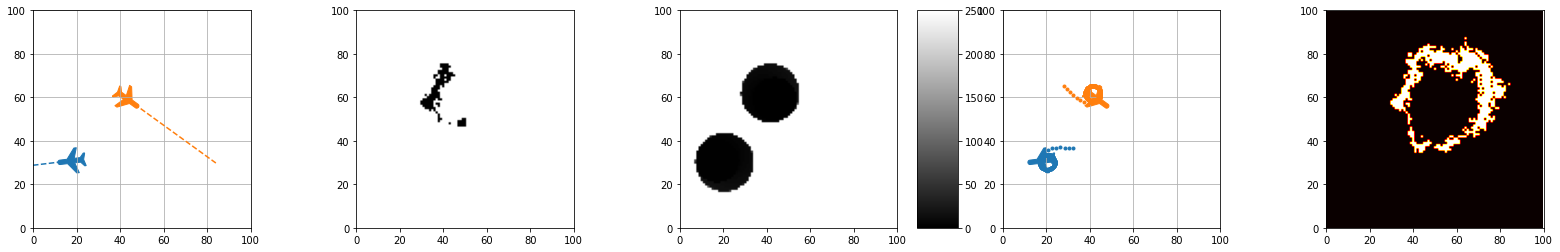

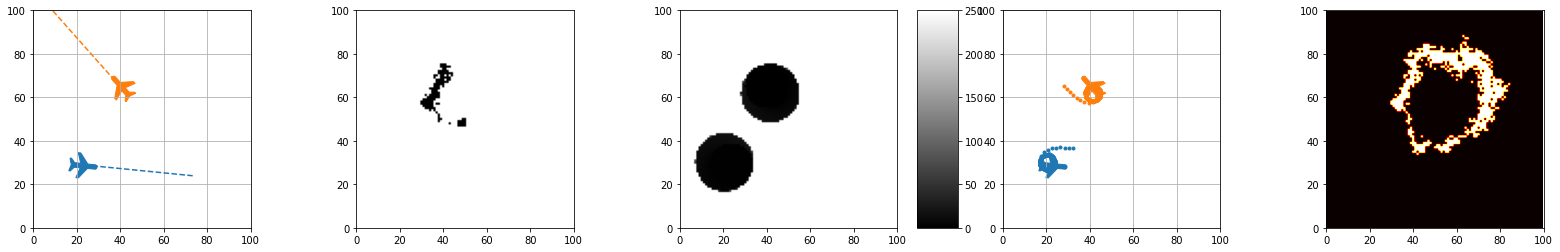

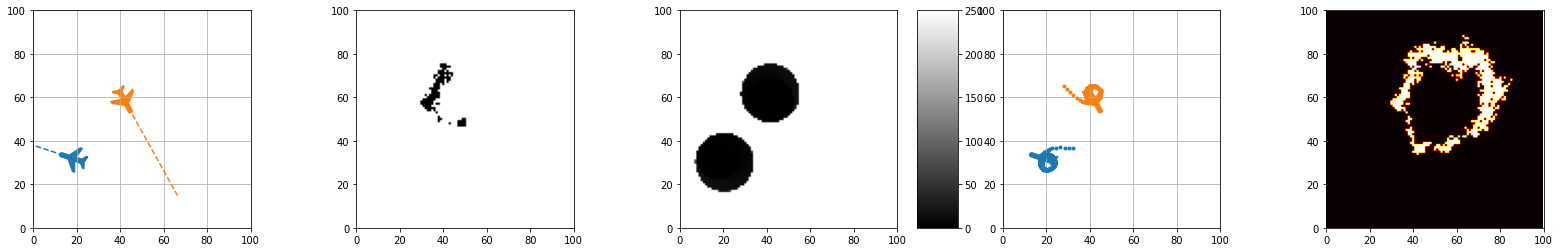

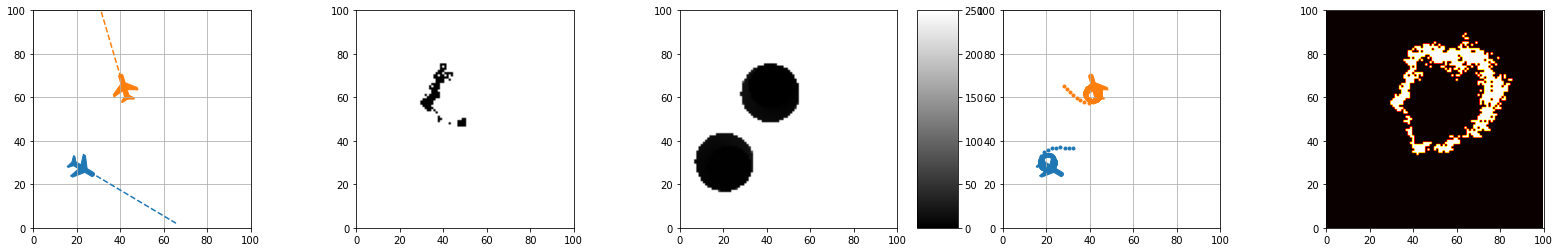

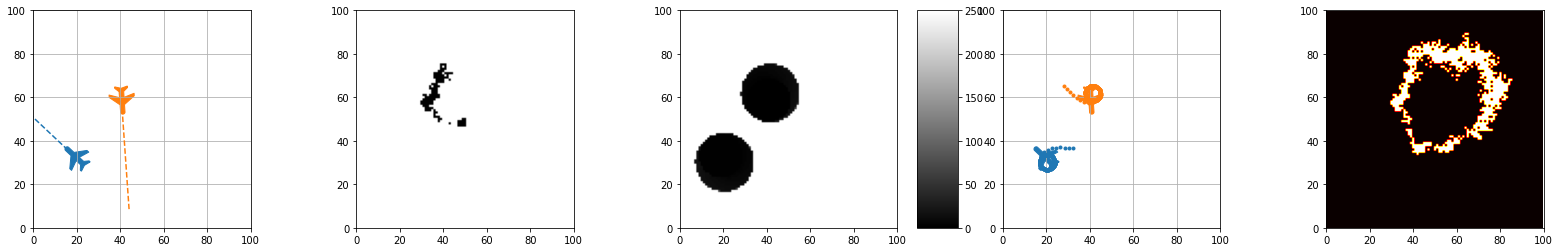

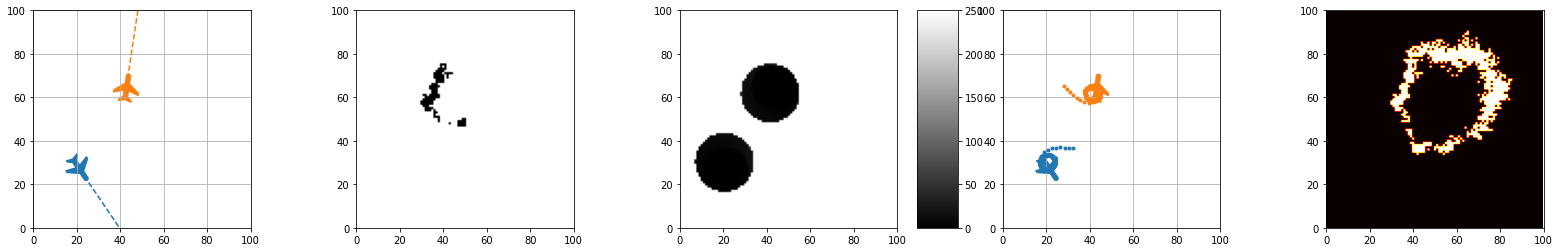

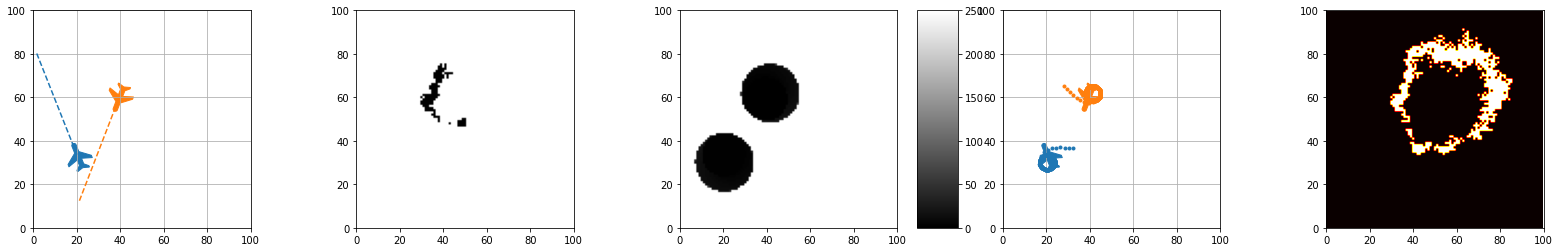

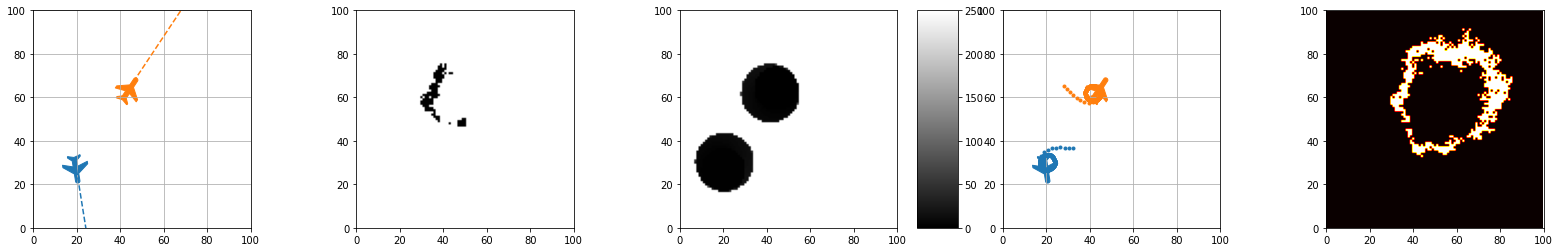

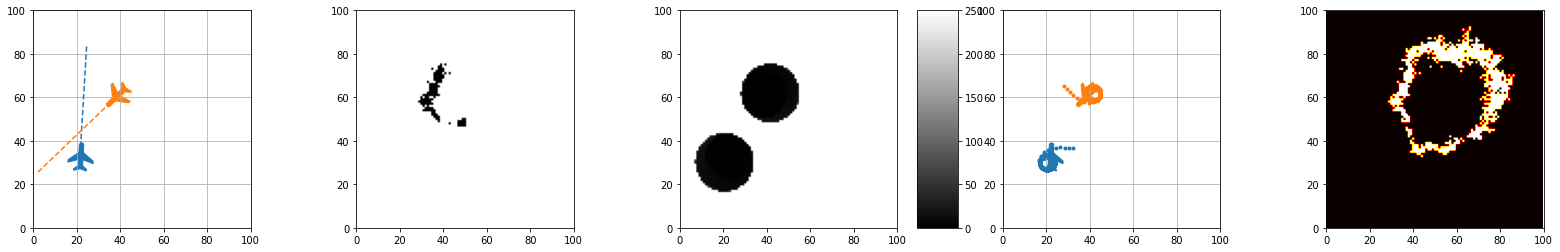

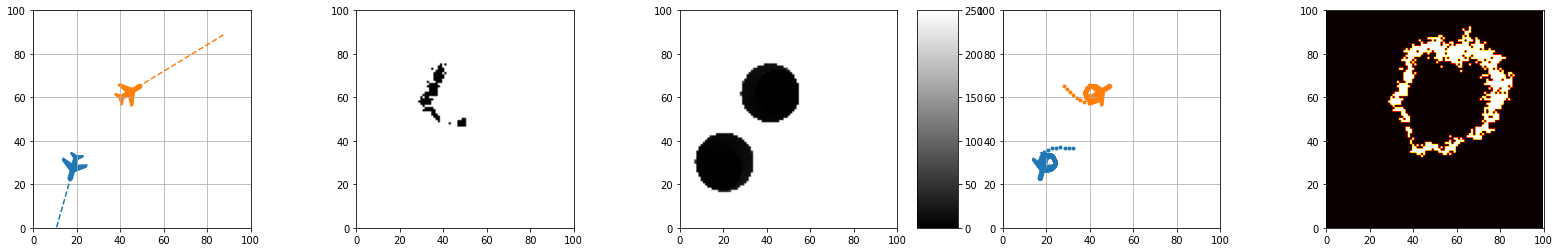

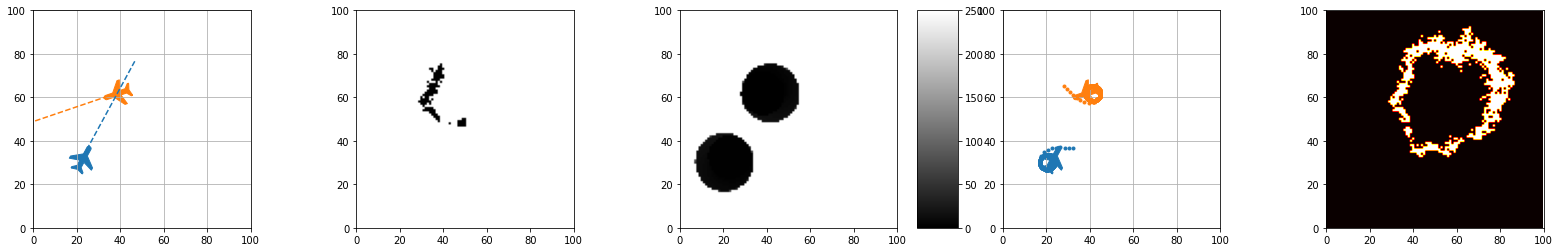

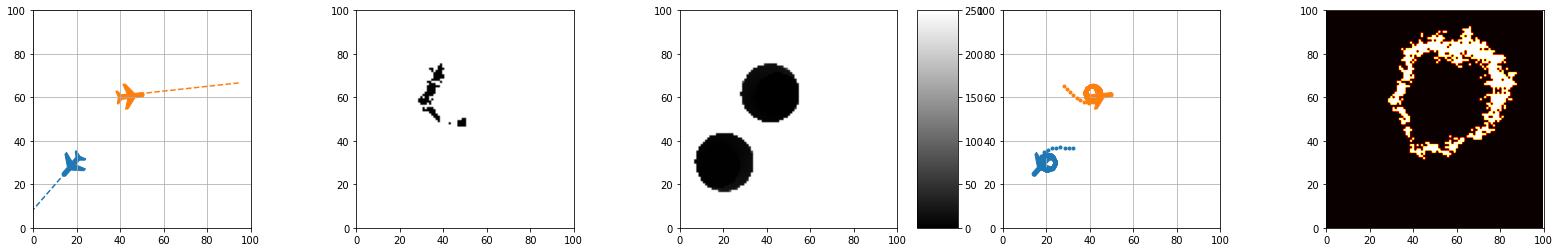

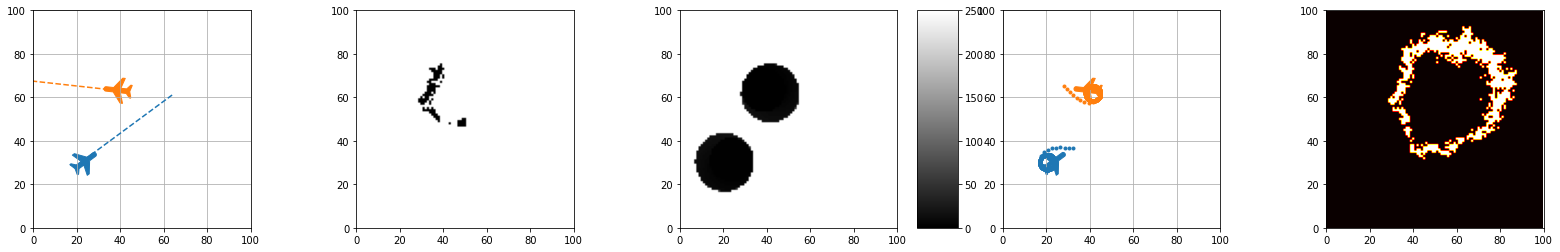

In [5]:
fireEnv = ProbabilisticFireEnv(height, width)
dronesEnv = DronesEnv(height, width, DT, DTI) 
loss = None
i_episode = 1
images = []
observation = fireEnv.reset()
dronesEnv.reset(observation)
hidden_1 = None
hidden_2 = None
while True:

  observation = fireEnv.step()

  state_vector_1 = dronesEnv.drones[0].state
  map_1 = dronesEnv.drones[0].observation
  state_vector_1 = torch.tensor(state_vector_1, device=device, dtype=torch.float)
  map_1 = torch.tensor(map_1, device=device, dtype=torch.float)

  state_vector_2 = dronesEnv.drones[1].state
  map_2 = dronesEnv.drones[1].observation
  state_vector_2 = torch.tensor(state_vector_2, device=device, dtype=torch.float)
  map_2 = torch.tensor(map_2, device=device, dtype=torch.float)

  for i in range(int(DT/DTI)):

    action1, hidden_1 = actor(map_1, state_vector_1, hidden_1)
    action2, hidden_2 = actor(map_2, state_vector_2, hidden_2)
    action1 = action1.max(1)[1].view(1, 1)
    action2 = action2.max(1)[1].view(1, 1)
    print(action1)
    dronesEnv.step([action1.item(), action2.item()], observation)

    next_state_vector_1 = dronesEnv.drones[0].state
    next_map_1 = dronesEnv.drones[0].observation

    next_state_vector_1 = torch.tensor(next_state_vector_1, device=device, dtype=torch.float)
    next_map_1 = torch.tensor(next_map_1, device=device, dtype=torch.float)

    next_state_vector_2 = dronesEnv.drones[1].state
    next_map_2 = dronesEnv.drones[1].observation

    next_state_vector_2 = torch.tensor(next_state_vector_2, device=device, dtype=torch.float)
    next_map_2 = torch.tensor(next_map_2, device=device, dtype=torch.float)

    state_vector_1 = next_state_vector_1
    state_vector_2 = next_state_vector_2

    map_1 = next_map_1
    map_2 = next_map_2

  if not fireEnv.fire_in_range(6):

    break

  fig, ax = plt.subplots(1, 5, figsize=(28, 4))
  dronesEnv.plot_drones(fig, ax[0])
  dronesEnv.plot_belief_map(fig, ax[1])
  dronesEnv.plot_time_elapsed(fig, ax[2])
  dronesEnv.plot_trajectory(fig, ax[3])
  fireEnv.plot_heat_map(fig, ax[4])
  fig.canvas.draw() 
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
  image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  images.append(image)

kwargs_write = {'fps':5.0, 'quantizer':'nq'}
imageio.mimsave('./ppo_example.gif', images, fps=5)
